# Pre Process the glider data
#### This notebook performs the following:

1) Loads glider data<br>
2) Subsets to passage crossings<br>
3) Interpolates temperature, salinity, and density onto a regular depth/latitude grid<br>
4) Calculates geostrophic velocity using the gliders depth-averaged current as a constraint<br>
5) Saves output in an xarray NetCDF

## Imports

In [1]:
import pandas as pd
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import glob
import pickle
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cpf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seawater as sw
import cmocean.cm as cmo
from scipy import integrate
from scipy.interpolate import griddata
import gsw
import sys
import matplotlib.dates as mdates


## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Slocum-AD2CP/src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data, dist_from_lat_lon

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')


## Load glider data

In [2]:
ds_id = 'ru29-20221116T1326-profile-sci-delayed'

## Load flight data
variables = ['depth', 'depth_interpolated','pressure','latitude', 'longitude', 'time', 'potential_temperature', 'salinity', 'oxygen_concentration_shifted','source_file', 'u', 'v']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

########## Convert variables for calculations
## Absolute salinity
SA = gsw.SA_from_SP(gdf.salinity.values, gdf.pressure.values, gdf.longitude.values, gdf.latitude.values)
gdf['absolute_salinity'] = SA
## Conservative temperature
CT = gsw.CT_from_t(SA, gdf.potential_temperature.values, gdf.pressure.values)
gdf['conservative_temperature'] = CT
## Potential density
sigma0  = gsw.sigma0(SA,CT)+1000
gdf['sigma0'] = sigma0

gdf

,depth,depth_interpolated,pressure,latitude,longitude,time,potential_temperature,salinity,oxygen_concentration_shifted,source_file,u,v,absolute_salinity,conservative_temperature,sigma0
0,0.009942,0.009942,0.01,14.534225,-61.105686,2022-11-16T13:29:51.41Z,28.380598,35.108273,NaN,ru29-2022-319-1-0-dbd(06560000),NaN,NaN,35.274327,28.382841,1022.351785
1,NaN,0.044738,NaN,14.534223,-61.105687,2022-11-16T13:29:52.97Z,NaN,NaN,194.861,ru29-2022-319-1-0-dbd(06560000),NaN,NaN,NaN,NaN,NaN
2,0.079534,0.079534,0.08,14.534221,-61.105692,2022-11-16T13:29:54.48Z,28.377481,35.109300,NaN,ru29-2022-319-1-0-dbd(06560000),NaN,NaN,35.275360,28.379658,1022.353591
3,0.069592,0.069592,0.07,14.534217,-61.105700,2022-11-16T13:29:56.48Z,28.377384,35.109097,NaN,ru29-2022-319-1-0-dbd(06560000),NaN,NaN,35.275156,28.379572,1022.353470
4,NaN,0.056337,NaN,14.534215,-61.105705,2022-11-16T13:29:57.88Z,NaN,NaN,194.840,ru29-2022-319-1-0-dbd(06560000),NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120890,NaN,1.347106,NaN,14.536617,-61.101049,2022-12-07T18:15:33.93Z,NaN,NaN,195.661,ru29-2022-336-0-77-dbd(06610077),NaN,NaN,NaN,NaN,NaN
1120891,1.193009,1.193009,1.20,14.536618,-61.101051,2022-12-07T18:15:34.94Z,28.244514,35.652910,NaN,ru29-2022-336-0-77-dbd(06610077),NaN,NaN,35.821547,28.223542,1022.806103
1120892,NaN,1.090278,NaN,14.536619,-61.101052,2022-12-07T18:15:35.95Z,NaN,NaN,195.496,ru29-2022-336-0-77-dbd(06610077),NaN,NaN,NaN,NaN,NaN
1120893,NaN,0.987547,NaN,14.536620,-61.101053,2022-12-07T18:15:36.40Z,NaN,NaN,NaN,ru29-2022-336-0-77-dbd(06610077),NaN,NaN,NaN,NaN,NaN


## Load a seperate dataframe for the flight params to get m_water_vx and m_water_vy

In [3]:
ds_id = 'ru29-20221116T1326-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time','source_file', 'm_water_vx', 'm_water_vy']
fgdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
fgdf.columns = variables

fgdf

,depth,latitude,longitude,time,source_file,m_water_vx,m_water_vy
0,0.0,14.534488,-61.106313,2022-11-16T13:26:40.63Z,ru29-2022-319-1-0-dbd(06560000),NaN,NaN
1,NaN,14.534488,-61.106313,2022-11-16T13:26:44.33Z,ru29-2022-319-1-0-dbd(06560000),0.0,0.0
2,NaN,14.534488,-61.106313,2022-11-16T13:26:45.29Z,ru29-2022-319-1-0-dbd(06560000),NaN,NaN
3,NaN,14.534488,-61.106313,2022-11-16T13:27:43.94Z,ru29-2022-319-1-0-dbd(06560000),0.0,0.0
4,NaN,14.534396,-61.106068,2022-11-16T13:28:06.80Z,ru29-2022-319-1-0-dbd(06560000),NaN,NaN
...,...,...,...,...,...,...,...
1443242,NaN,14.305292,-60.979360,2022-12-03T22:03:06.21Z,ru29-2022-336-0-9-dbd(06610009),NaN,NaN
1443243,NaN,14.305292,-60.979360,2022-12-03T22:03:11.04Z,ru29-2022-336-0-9-dbd(06610009),NaN,NaN
1443244,NaN,14.305292,-60.979360,2022-12-03T22:03:15.85Z,ru29-2022-336-0-9-dbd(06610009),NaN,NaN
1443245,NaN,14.305292,-60.979360,2022-12-03T22:03:20.64Z,ru29-2022-336-0-9-dbd(06610009),NaN,NaN


In [4]:
## number of "files"
ind_sf = np.unique(fgdf.source_file)

## pre-allocate
d = {'source_file': np.empty(len(ind_sf)), 'vx': np.empty(len(ind_sf)), 'vy': np.empty(len(ind_sf))}
dac_df = pd.DataFrame(data=d)
dac_df[:] = np.nan
dac_df['source_file'].astype(str)

for x in np.arange(0,len(ind_sf)):
    subset_fgdf = fgdf[fgdf.source_file == ind_sf[x]]
    
    ind_vx = np.unique(subset_fgdf.m_water_vx)
    ind_vx = np.unique(ind_vx[~np.isnan(ind_vx)])
    ind_vx = np.unique(ind_vx[ind_vx!=0])
    
    ind_vy = np.unique(subset_fgdf.m_water_vy)
    ind_vy = np.unique(ind_vy[~np.isnan(ind_vy)])
    ind_vy = np.unique(ind_vy[ind_vy!=0])
    
    dac_df['source_file'][x] = subset_fgdf['source_file'].iloc[0]
    if len(ind_vx) > 1:
        dac_df['vx'][x] = ind_vx[-1]
    elif len(ind_vx) == 1:
        dac_df['vx'][x] = ind_vx
    if len(ind_vy) > 1:
        dac_df['vy'][x] = ind_vy[-1]
    elif len(ind_vy) == 1:
        dac_df['vy'][x] = ind_vy



/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/joegradone/opt/anaconda3/lib/python3.7/sit

In [5]:
dac_df

,source_file,vx,vy
0,ru29-2022-319-1-0-dbd(06560000),0.026180,-0.035467
1,ru29-2022-319-2-0-dbd(06570000),0.033848,-0.029531
2,ru29-2022-319-2-1-dbd(06570001),0.005222,-0.038649
3,ru29-2022-319-2-10-dbd(06570010),0.012424,-0.012311
4,ru29-2022-319-2-11-dbd(06570011),0.012424,-0.021815
...,...,...,...
339,ru29-2022-336-0-75-dbd(06610075),-0.010177,-0.051714
340,ru29-2022-336-0-76-dbd(06610076),-0.010177,-0.116923
341,ru29-2022-336-0-77-dbd(06610077),-0.010177,-0.099477
342,ru29-2022-336-0-8-dbd(06610008),-0.185188,0.099897


## Now add the DAC back into the master DF

In [6]:
for x in np.arange(0,len(dac_df.source_file)):
    ind = np.where(gdf.source_file.values == dac_df.source_file.iloc[x])[0]
    gdf.u.iloc[ind] = dac_df.vx.iloc[x]
    gdf.v.iloc[ind] = dac_df.vy.iloc[x]


/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [7]:
gdf

,depth,depth_interpolated,pressure,latitude,longitude,time,potential_temperature,salinity,oxygen_concentration_shifted,source_file,u,v,absolute_salinity,conservative_temperature,sigma0
0,0.009942,0.009942,0.01,14.534225,-61.105686,2022-11-16T13:29:51.41Z,28.380598,35.108273,NaN,ru29-2022-319-1-0-dbd(06560000),0.026180,-0.035467,35.274327,28.382841,1022.351785
1,NaN,0.044738,NaN,14.534223,-61.105687,2022-11-16T13:29:52.97Z,NaN,NaN,194.861,ru29-2022-319-1-0-dbd(06560000),0.026180,-0.035467,NaN,NaN,NaN
2,0.079534,0.079534,0.08,14.534221,-61.105692,2022-11-16T13:29:54.48Z,28.377481,35.109300,NaN,ru29-2022-319-1-0-dbd(06560000),0.026180,-0.035467,35.275360,28.379658,1022.353591
3,0.069592,0.069592,0.07,14.534217,-61.105700,2022-11-16T13:29:56.48Z,28.377384,35.109097,NaN,ru29-2022-319-1-0-dbd(06560000),0.026180,-0.035467,35.275156,28.379572,1022.353470
4,NaN,0.056337,NaN,14.534215,-61.105705,2022-11-16T13:29:57.88Z,NaN,NaN,194.840,ru29-2022-319-1-0-dbd(06560000),0.026180,-0.035467,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120890,NaN,1.347106,NaN,14.536617,-61.101049,2022-12-07T18:15:33.93Z,NaN,NaN,195.661,ru29-2022-336-0-77-dbd(06610077),-0.010177,-0.099477,NaN,NaN,NaN
1120891,1.193009,1.193009,1.20,14.536618,-61.101051,2022-12-07T18:15:34.94Z,28.244514,35.652910,NaN,ru29-2022-336-0-77-dbd(06610077),-0.010177,-0.099477,35.821547,28.223542,1022.806103
1120892,NaN,1.090278,NaN,14.536619,-61.101052,2022-12-07T18:15:35.95Z,NaN,NaN,195.496,ru29-2022-336-0-77-dbd(06610077),-0.010177,-0.099477,NaN,NaN,NaN
1120893,NaN,0.987547,NaN,14.536620,-61.101053,2022-12-07T18:15:36.40Z,NaN,NaN,NaN,ru29-2022-336-0-77-dbd(06610077),-0.010177,-0.099477,NaN,NaN,NaN


## Subset by time for the passage crossings

In [30]:
start_time = '2022-11-18T12:00:00Z'
end_time   = '2022-11-20T10:00:00Z'
## First subset by time
df = gdf[(gdf.time>= start_time) & (gdf.time<=end_time)]

## Now actuallly subset by file names so we get the full record
start_file = df.source_file.iloc[0]
end_file = df.source_file.iloc[-1]

## New start and end times because can't trust subsetting by file name is in ORDER
new_start_time = gdf[gdf.source_file == start_file].time.min()
new_end_time = gdf[gdf.source_file == end_file].time.max()

df = gdf[(gdf.time>= new_start_time) & (gdf.time<=new_end_time)]
df

,depth,depth_interpolated,pressure,latitude,longitude,time,potential_temperature,salinity,oxygen_concentration_shifted,source_file,u,v,absolute_salinity,conservative_temperature,sigma0
78930,0.029825,0.029825,0.03,14.867000,-61.277625,2022-11-18T12:11:52.12Z,28.209892,35.152473,NaN,ru29-2022-320-0-17-dbd(06580017),-0.136881,-0.051957,35.318723,28.209941,1022.441260
78931,0.049708,0.049708,0.05,14.867000,-61.277626,2022-11-18T12:11:54.13Z,28.210989,35.154583,194.206,ru29-2022-320-0-17-dbd(06580017),-0.136881,-0.051957,35.320843,28.210947,1022.442486
78932,0.089475,0.089475,0.09,14.867000,-61.277627,2022-11-18T12:11:56.13Z,28.214579,35.152800,194.185,ru29-2022-320-0-17-dbd(06580017),-0.136881,-0.051957,35.319051,28.214609,1022.439968
78933,NaN,0.099416,NaN,14.867000,-61.277628,2022-11-18T12:11:57.92Z,NaN,NaN,NaN,ru29-2022-320-0-17-dbd(06580017),-0.136881,-0.051957,NaN,NaN,NaN
78934,0.109358,0.109358,0.11,14.867000,-61.277629,2022-11-18T12:11:58.14Z,28.216873,35.153460,194.181,ru29-2022-320-0-17-dbd(06580017),-0.136881,-0.051957,35.319715,28.216876,1022.439711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220026,NaN,1.173093,NaN,15.158633,-61.316424,2022-11-20T12:35:07.23Z,NaN,NaN,NaN,ru29-2022-320-0-47-dbd(06580047),-0.095789,-0.012812,NaN,NaN,NaN
220027,1.043854,1.043854,1.05,15.158633,-61.316423,2022-11-20T12:35:08.23Z,28.179352,35.596786,NaN,ru29-2022-320-0-47-dbd(06580047),-0.095789,-0.012812,35.765130,28.160656,1022.785357
220028,NaN,0.957695,NaN,15.158634,-61.316422,2022-11-20T12:35:09.24Z,NaN,NaN,NaN,ru29-2022-320-0-47-dbd(06580047),-0.095789,-0.012812,NaN,NaN,NaN
220029,NaN,0.871536,NaN,15.158634,-61.316421,2022-11-20T12:35:09.47Z,NaN,NaN,NaN,ru29-2022-320-0-47-dbd(06580047),-0.095789,-0.012812,NaN,NaN,NaN


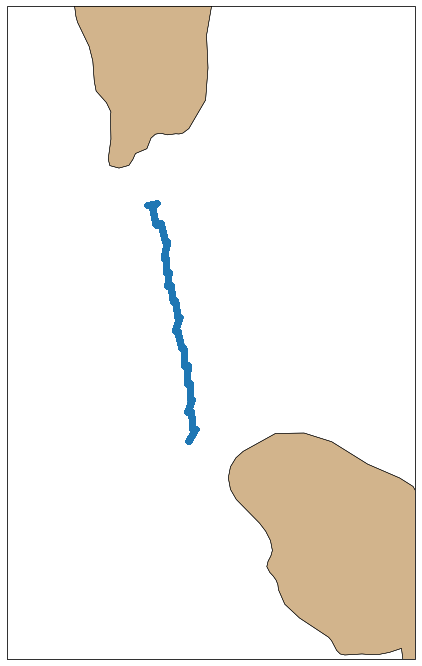

In [31]:
## Map extent
lon1 = -61.5
lon2 = -61
lat1 = 14.6
lat2 = 15.4

fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lon1, lon2, lat1, lat2])
LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='tan'
)
ax.add_feature(LAND, zorder=0)

plt.plot(df.longitude.values,df.latitude.values,'.')


In [32]:
def calc_transect_angle(df):
    df2 = df.sort_values('latitude')
    
    def latlong_to_3d(latr, lonr):
        """Convert a point given latitude and longitude in radians to
        3-dimensional space, assuming a sphere radius of one."""
        return np.array((
            math.cos(latr) * math.cos(lonr),
            math.cos(latr) * math.sin(lonr),
            math.sin(latr)
        ))

    def angle_between_vectors_degrees(u, v):
        """Return the angle between two vectors in any dimension space,
        in degrees."""
        return np.degrees(
            math.acos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))))

    # The points in tuple latitude/longitude degrees space
    A = (df2.longitude.values[0],df2.latitude.values[0])
    B = (df2.longitude.values[-1],df2.latitude.values[-1])
    C = (df2.longitude.values[-1],df2.latitude.values[0])

    # Convert the points to numpy latitude/longitude radians space
    a = np.radians(np.array(A))
    b = np.radians(np.array(B))
    c = np.radians(np.array(C))

    # The points in 3D space
    a3 = latlong_to_3d(*a)
    b3 = latlong_to_3d(*b)
    c3 = latlong_to_3d(*c)

    # Vectors in 3D space
    a3vec = a3 - b3
    c3vec = c3 - b3

    # Find the angle between the vectors in 2D space
    angle = angle_between_vectors_degrees(a3vec, c3vec)
    
    return angle


def subsect_to_transect_df_to_transport_ds(df, start_time, end_time, lat_grid_dy=0.05, geo_dz=2):
    df = df[(df.time>= start_time) & (df.time<=end_time)]
    
    ## Now actuallly subset by file names so we get the full record
    start_file = df.source_file.iloc[0]
    end_file = df.source_file.iloc[-1]
    
    ## New start and end times because can't trust subsetting by file name is in ORDER
    new_start_time = gdf[gdf.source_file == start_file].time.min()
    new_end_time = gdf[gdf.source_file == end_file].time.max()
    
    df = gdf[(gdf.time>= new_start_time) & (gdf.time<=new_end_time)]
    ## first drop where lon/lat are nan
    df = df[df['sigma0'].notna()]
    
    ## then drop where lon/lat are nan
    df = df[df['latitude'].notna()]

    ## find min and max latitude for lat grid
    min_lat = df.latitude.values.min()
    max_lat = df.latitude.values.max()
    min_lon = df.longitude.values.min()
    max_lon = df.longitude.values.max()
    ## make latitude grid
    lat_gridt = np.arange(min_lat, max_lat, lat_grid_dy) 
    ## take the mean longitude for calculating the grid distance
    mean_lon = np.nanmean(df.longitude.values)

    ## this is the grid dy in meters then (0.05 degree latitude grid sizing is ~5.5 km)
    #dy = dist_from_lat_lon(lat_gridt[0],mean_lon,lat_gridt[1],mean_lon)
    ## this is the grid dy in meters, actually using the "angle" of the transect by using the true start and end lon
    ## (keep checking if 0.05 degree latitude grid sizing is ~5.8 km)
    dy = dist_from_lat_lon(min_lat,min_lon,max_lat,max_lon)/len(lat_gridt)
    transect_dist = dist_from_lat_lon(min_lat,min_lon,max_lat,max_lon)

    ## Now make the vertical (depth) grid
    ## for the depth grid just go to the max depth rounded to the nearest geo_dz'th place (i.e. geo_dz = 2, round to 911 m to 912)
    max_depth = round(df.depth_interpolated.max()/2)*2
    depth_gridt = np.arange(0,max_depth,geo_dz)

    ## now turn the temporary 1D grids into a 2D grid
    lat_grid, depth_grid = np.meshgrid(lat_gridt,depth_gridt)

    ## do the interpolation
    griddensity      = griddata((df.latitude.values,df.depth.values), df.sigma0, (lat_grid, depth_grid), method='linear')
    ## also do it for t,s,O2 because that's what the analysis will eventually focus on
    gridtemperature  = griddata((df.latitude.values,df.depth.values), df.conservative_temperature, (lat_grid, depth_grid), method='linear')
    gridsalinity     = griddata((df.latitude.values,df.depth.values), df.absolute_salinity, (lat_grid, depth_grid), method='linear')
    gridoxygen       = griddata((df.latitude.values,df.depth_interpolated.values), df.oxygen_concentration_shifted, (lat_grid, depth_grid), method='linear')
    
    ## now get the depth averaged current on this latitude grid
    grid_du = np.empty(len(lat_gridt))
    grid_du[:] = 0
    ## also do this for the mean oxygen time shift, not as meaningful but still want to keep track of it
    mean_time_shift = np.empty(len(lat_gridt))
    mean_time_shift[:] = np.nan

    ## Loop to compile DAC in each latitude bin and take mean
    for x in np.arange(0,len(lat_gridt)-1):
        subset_df = df[(df.latitude >= lat_gridt[x]) & (df.latitude <= lat_gridt[x+1])]
        ## Do a quick DAC QAQC, set DAC greater than 10 m/s to nan
        subset_df.u[np.abs(subset_df.u) > 5] = np.nan
        ## take mean DAC in that latitude bin
        grid_du[x] = np.nanmean(subset_df.u.values)

    
    ## drop column if all are na
    drop_ind = ~np.all(np.isnan(griddensity), axis=0)

    griddensity = griddensity[:,drop_ind]
    gridtemperature = gridtemperature[:,drop_ind]
    gridsalinity = gridsalinity[:,drop_ind]
    gridoxygen = gridoxygen[:,drop_ind]
    grid_du = grid_du[drop_ind]
    lat_gridt = lat_gridt[drop_ind]

    ## Calculate d(rho)/d(y)
    d_rho_dy = np.gradient(griddensity,dy,axis=1)

    ## Calculate d(u)/d(z)
    CF = sw.extras.f(df.latitude.values.mean())
    g = sw.eos80.g(df.latitude.values.mean(), 0)
    therm_wind = (1/CF)*(g/1027)*d_rho_dy

    ## Now integrate d(u)/d(z) vertically to get u
    ## replace nan with zeros for integration
    #therm_wind[np.where(np.isnan(therm_wind) ==True)] = 0
    ## drop column if all are na
    #therm_wind = therm_wind[:,~np.all(np.isnan(therm_wind), axis=0)]

    ## flip to integrate from bottom and then flip back, this puts the level of no motion at the bottom of the profile
    rel_Vg = integrate.cumtrapz(therm_wind[::-1,:], dx=geo_dz, initial=0, axis=0)[::-1,:]

    ## Now add the reference velocity
    vref = grid_du - np.nanmean(rel_Vg,axis=0)
    Vgeo = rel_Vg + vref
    
    ## Determine transect angle off vertical and rotate geostrophic velocity to EW
    VgeoEW = Vgeo*np.cos(np.deg2rad(calc_transect_angle(df)))
    
    ## Calculate mid-point time
    start_time = np.nanmin(pd.to_datetime(df.time[df['time'].notna()]))
    end_time   = np.nanmax(pd.to_datetime(df.time[df['time'].notna()]))
    dt = (end_time-start_time)/2
    mid_time = pd.to_datetime(df.time.values)[0]+dt

    ## Now save!
    geo_grid_ds = xr.Dataset(
        data_vars=dict(
            Vgeo =(["depth", "latitude"], Vgeo),
            VgeoEW =(["depth", "latitude"], VgeoEW),
            density =(["depth", "latitude"], griddensity),
            temperature =(["depth", "latitude"], gridtemperature),
            salinity =(["depth", "latitude"], gridsalinity),
            oxygen =(["depth", "latitude"], gridoxygen),
            mean_du = (["latitude"],grid_du)),
        coords=dict(
            depth      = depth_gridt,
            latitude   = lat_gridt,
            start_time = start_time,
            end_time   = end_time,
            mid_time   = mid_time,
        ),
        attrs={'description': "Processed geostrophic velocity, temperature, salinity, density and time shifted oxygen gridded/interpolated onto transect latitude and depth grid",
        'min_lon': min_lon,
        'max_lon': max_lon,
        'mean_lon': mean_lon,
        'geo_dz': geo_dz,
        'dy': dy,
        'transect_dist': transect_dist}
    )

    return geo_grid_ds
    

In [33]:
dominica_df1 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2022-11-18T12:00:00Z', end_time   = '2022-11-20T10:00:00Z', lat_grid_dy=0.06,geo_dz=5)

save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/Dominica_Transect_1_2022.nc'

dominica_df1.to_netcdf(save_name)



/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [34]:
dominica_df1

<xarray.Dataset>
Dimensions:      (depth: 190, latitude: 4)
Coordinates:
  * depth        (depth) int64 0 5 10 15 20 25 30 ... 920 925 930 935 940 945
  * latitude     (latitude) float64 14.93 14.99 15.05 15.11
    start_time   datetime64[ns] 2022-11-18T12:11:52.120000
    end_time     datetime64[ns] 2022-11-20T12:35:10.250000
    mid_time     datetime64[ns] 2022-11-19T12:23:31.185000
Data variables:
    Vgeo         (depth, latitude) float64 nan nan nan ... -0.1504 -0.08503
    VgeoEW       (depth, latitude) float64 nan nan nan ... -0.145 -0.08197
    density      (depth, latitude) float64 nan nan nan ... 1.027e+03 1.028e+03
    temperature  (depth, latitude) float64 nan nan nan 28.2 ... 5.55 5.551 5.612
    salinity     (depth, latitude) float64 nan nan nan 35.76 ... 35.0 35.0 35.06
    oxygen       (depth, latitude) float64 nan nan nan nan ... nan nan nan nan
    mean_du      (latitude) float64 -0.0924 -0.09841 -0.09078 0.0
Attributes:
    description:    Processed geostrophic velocity, temperature, salinity, de...
    min_lon:        -61.32797494570645
    max_lon:        -61.2690032255228
    mean_lon:       -61.293746483830674
    geo_dz:         5
    dy:             6612.552558783163
    transect_dist:  33062.76279391581

Text(0.5, 0, 'Latitude')

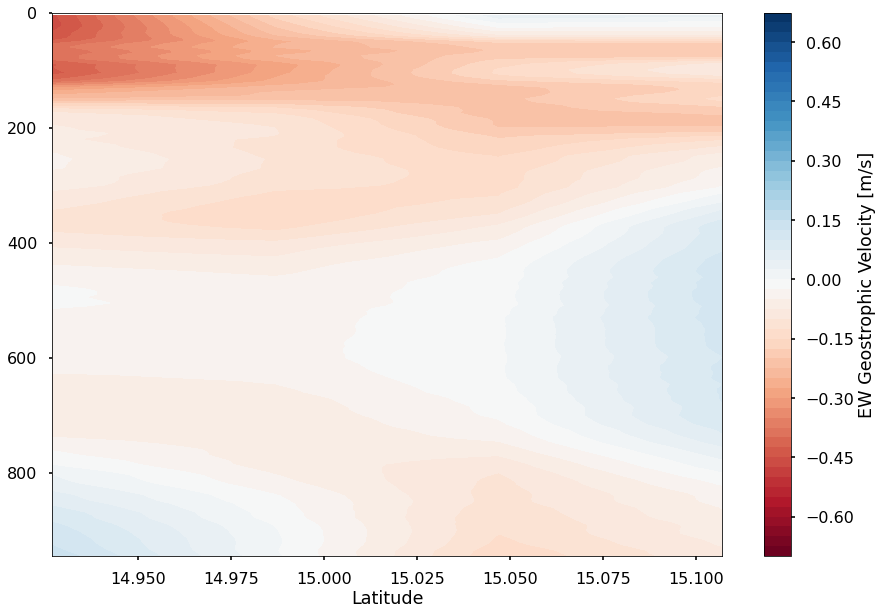

In [35]:
plt.figure(figsize=(15,10))
plt.contourf(dominica_df1.latitude,dominica_df1.depth,dominica_df1.VgeoEW,cmap='RdBu',levels=np.arange(-0.7,0.7,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

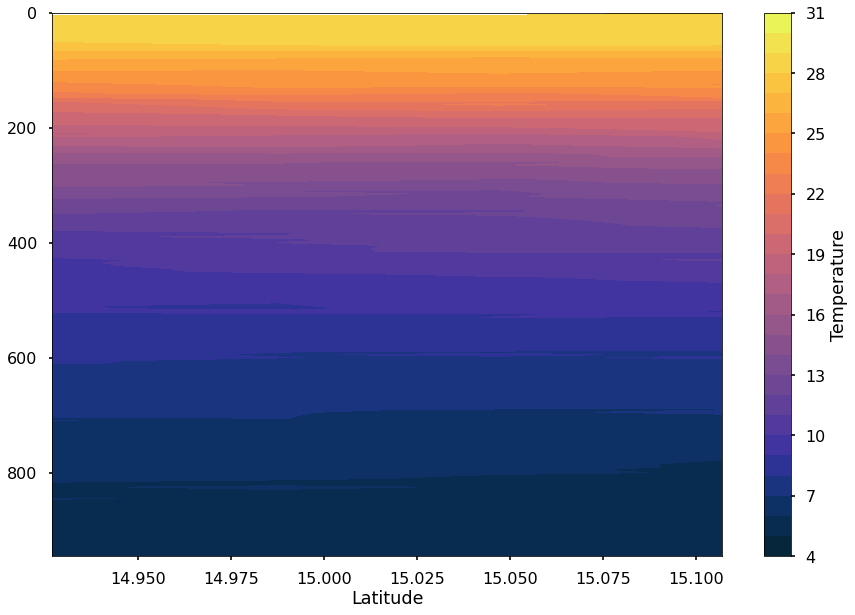

In [36]:
plt.figure(figsize=(15,10))
plt.contourf(dominica_df1.latitude,dominica_df1.depth,dominica_df1.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

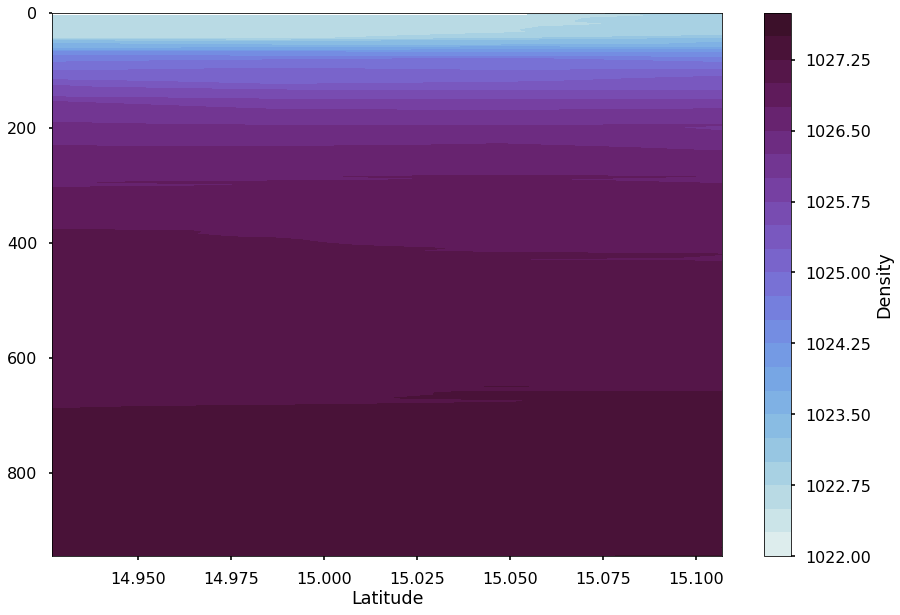

In [37]:
plt.figure(figsize=(15,10))
plt.contourf(dominica_df1.latitude,dominica_df1.depth,dominica_df1.density,cmap=cmo.dense,levels=np.arange(1022,1028,0.25))
plt.gca().invert_yaxis()
plt.colorbar(label='Density')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

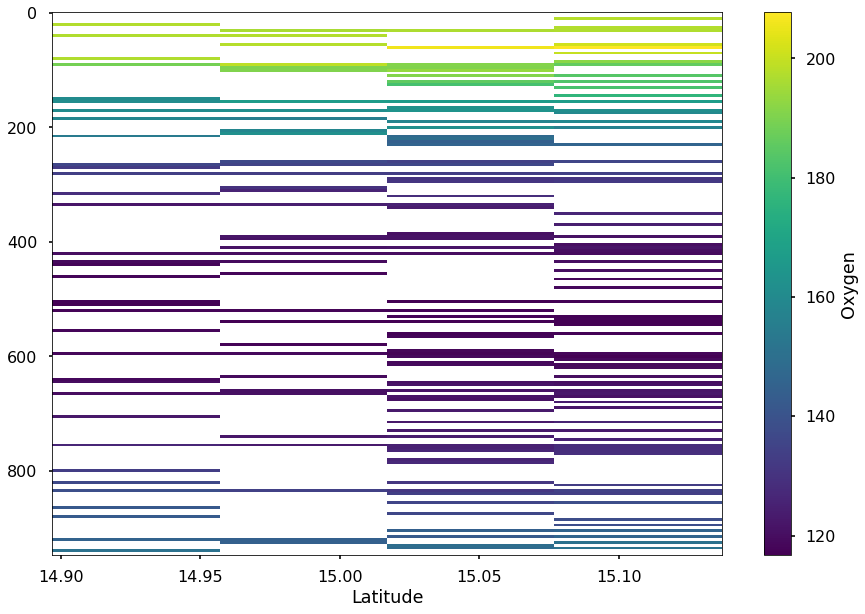

In [38]:
plt.figure(figsize=(15,10))
plt.pcolormesh(dominica_df1.latitude,dominica_df1.depth,dominica_df1.oxygen)
plt.gca().invert_yaxis()
plt.colorbar(label='Oxygen')
plt.xlabel('Latitude')

## Dominica transect #2

In [39]:
dominica_df2 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2022-11-20T12:00:00Z', end_time = '2022-11-21T13:00:00Z', lat_grid_dy=0.06,geo_dz=5)

save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/Dominica_Transect_2_2022.nc'

dominica_df2.to_netcdf(save_name)


dominica_df2

/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


<xarray.Dataset>
Dimensions:      (depth: 190, latitude: 4)
Coordinates:
  * depth        (depth) int64 0 5 10 15 20 25 30 ... 920 925 930 935 940 945
  * latitude     (latitude) float64 14.94 15.0 15.06 15.12
    start_time   datetime64[ns] 2022-11-20T09:45:01.760000
    end_time     datetime64[ns] 2022-11-21T13:05:18.800000
    mid_time     datetime64[ns] 2022-11-20T23:25:10.280000
Data variables:
    Vgeo         (depth, latitude) float64 0.0837 0.1495 ... -0.0536 -0.02293
    VgeoEW       (depth, latitude) float64 0.07836 0.14 ... -0.05018 -0.02147
    density      (depth, latitude) float64 1.022e+03 1.022e+03 ... 1.027e+03
    temperature  (depth, latitude) float64 28.28 28.23 28.2 ... 5.568 5.598
    salinity     (depth, latitude) float64 35.3 35.36 35.56 ... 35.03 35.0 35.01
    oxygen       (depth, latitude) float64 nan nan nan nan ... nan nan nan nan
    mean_du      (latitude) float64 -0.07955 -0.1057 -0.08312 0.0
Attributes:
    description:    Processed geostrophic velocity, temperature, salinity, de...
    min_lon:        -61.32797494570645
    max_lon:        -61.26551858492382
    mean_lon:       -61.294050767077316
    geo_dz:         5
    dy:             6424.482069096432
    transect_dist:  32122.41034548216

Text(0.5, 0, 'Latitude')

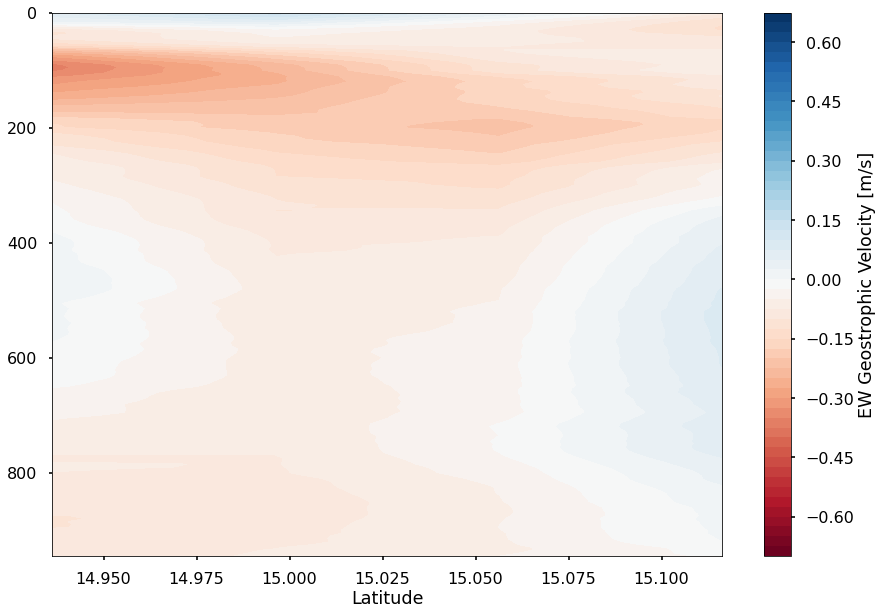

In [40]:
plt.figure(figsize=(15,10))
plt.contourf(dominica_df2.latitude,dominica_df2.depth,dominica_df2.VgeoEW,cmap='RdBu',levels=np.arange(-0.7,0.7,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

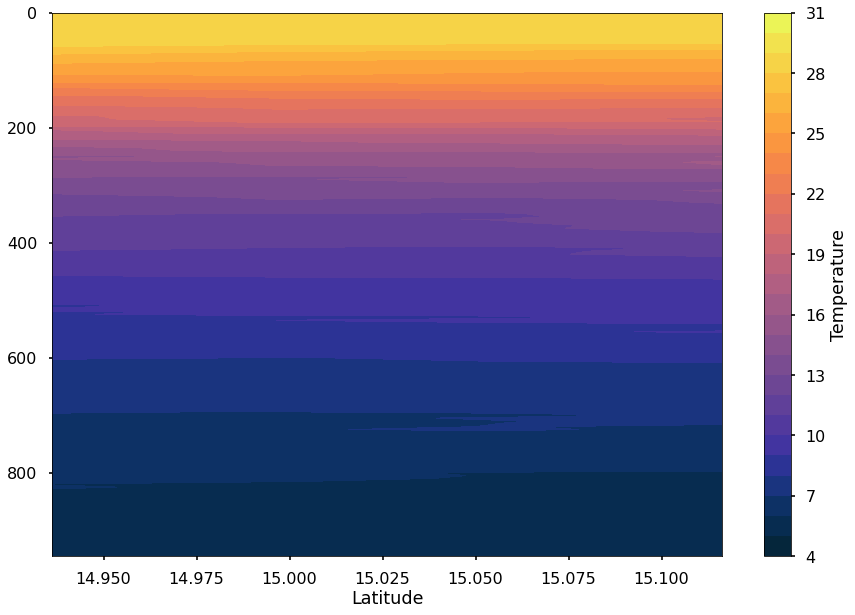

In [41]:
plt.figure(figsize=(15,10))
plt.contourf(dominica_df2.latitude,dominica_df2.depth,dominica_df2.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

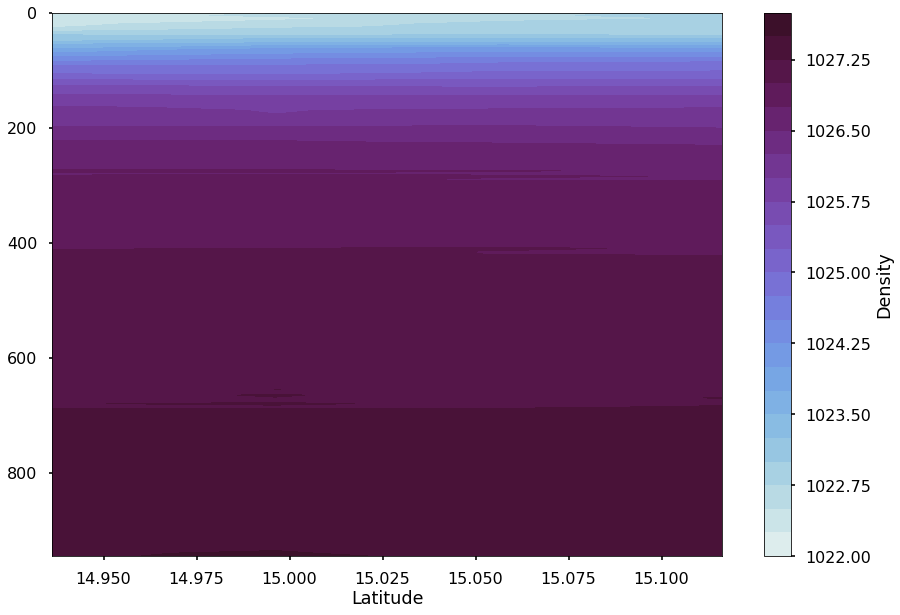

In [42]:
plt.figure(figsize=(15,10))
plt.contourf(dominica_df2.latitude,dominica_df2.depth,dominica_df2.density,cmap=cmo.dense,levels=np.arange(1022,1028,0.25))
plt.gca().invert_yaxis()
plt.colorbar(label='Density')
plt.xlabel('Latitude')

## St Vincent #1

In [43]:
stvin_df1 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2022-11-27T08:00:00Z', end_time = '2022-11-29T03:00:00Z', lat_grid_dy=0.06,geo_dz=5)

save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/St_Vincent_Transect_1_2022.nc'

stvin_df1.to_netcdf(save_name)

stvin_df1

/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


<xarray.Dataset>
Dimensions:      (depth: 191, latitude: 6)
Coordinates:
  * depth        (depth) int64 0 5 10 15 20 25 30 ... 925 930 935 940 945 950
  * latitude     (latitude) float64 13.48 13.54 13.6 13.66 13.72 13.78
    start_time   datetime64[ns] 2022-11-27T06:33:33.580000
    end_time     datetime64[ns] 2022-11-29T03:09:04.480000
    mid_time     datetime64[ns] 2022-11-28T04:51:19.030000
Data variables:
    Vgeo         (depth, latitude) float64 -1.191 -0.8625 ... 0.0419 0.007247
    VgeoEW       (depth, latitude) float64 -1.157 -0.8378 ... 0.0407 0.00704
    density      (depth, latitude) float64 1.023e+03 1.023e+03 ... 1.028e+03
    temperature  (depth, latitude) float64 28.05 28.04 28.02 ... 4.812 5.019
    salinity     (depth, latitude) float64 35.79 35.79 35.74 ... 35.07 35.05
    oxygen       (depth, latitude) float64 nan nan nan nan ... nan nan nan nan
    mean_du      (latitude) float64 -0.07441 -0.08409 -0.02814 ... -0.02296 0.0
Attributes:
    description:    Processed geostrophic velocity, temperature, salinity, de...
    min_lon:        -61.19116370575168
    max_lon:        -61.12242217022381
    mean_lon:       -61.1547699559438
    geo_dz:         5
    dy:             6740.441878944584
    transect_dist:  47183.093152612084

Text(0.5, 0, 'Latitude')

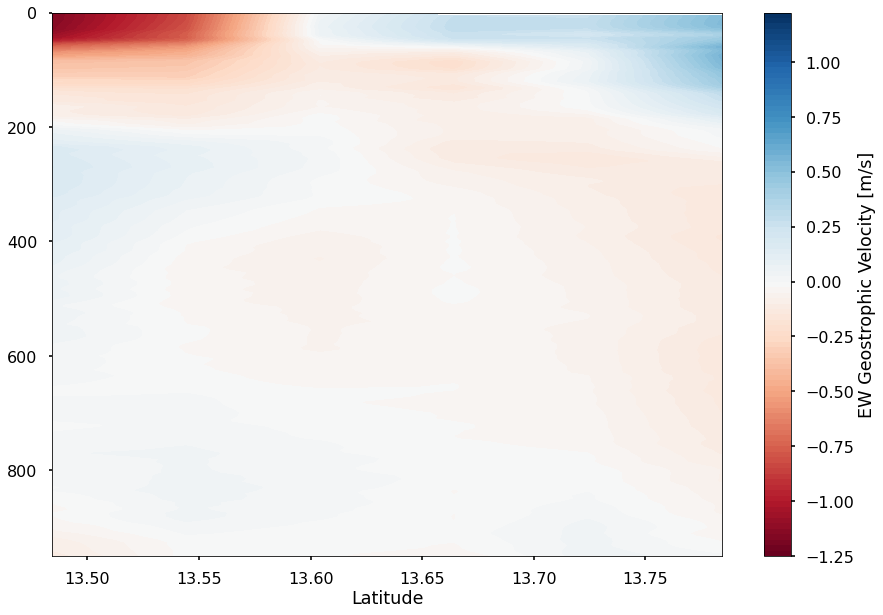

In [44]:
plt.figure(figsize=(15,10))
plt.contourf(stvin_df1.latitude,stvin_df1.depth,stvin_df1.VgeoEW,cmap='RdBu',levels=np.arange(-1.25,1.25,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

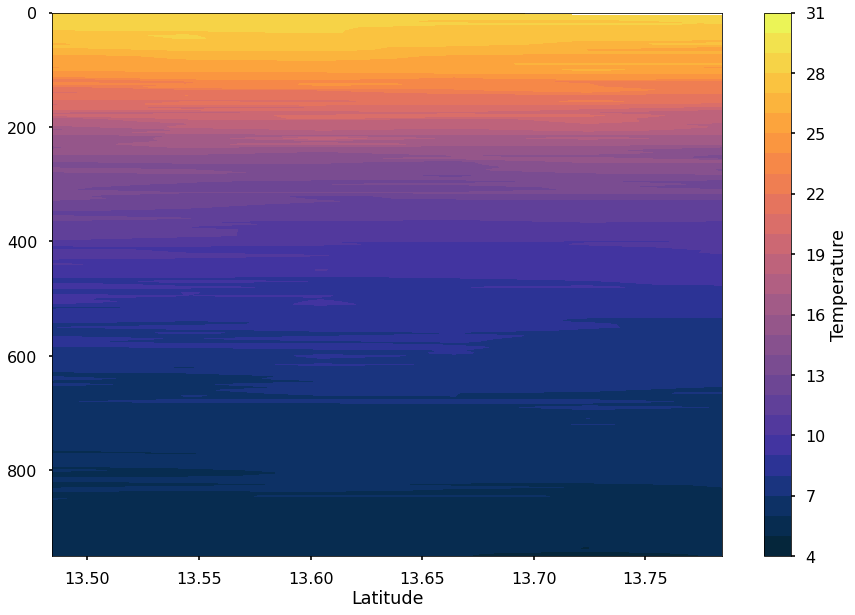

In [45]:
plt.figure(figsize=(15,10))
plt.contourf(stvin_df1.latitude,stvin_df1.depth,stvin_df1.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

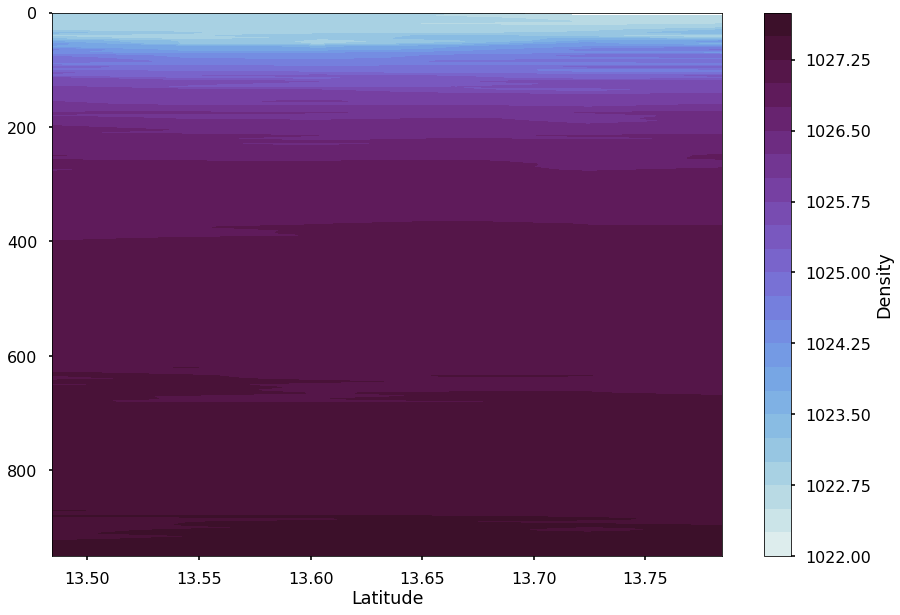

In [46]:
plt.figure(figsize=(15,10))
plt.contourf(stvin_df1.latitude,stvin_df1.depth,stvin_df1.density,cmap=cmo.dense,levels=np.arange(1022,1028,0.25))
plt.gca().invert_yaxis()
plt.colorbar(label='Density')
plt.xlabel('Latitude')

## St. Vincent #2

In [47]:
stvin_df2 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2022-11-29T03:30:00Z', end_time   = '2022-12-01T04:00:00Z', lat_grid_dy=0.06,geo_dz=5)

save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/St_Vincent_Transect_2_2022.nc'

stvin_df2.to_netcdf(save_name)

stvin_df2

/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


<xarray.Dataset>
Dimensions:      (depth: 191, latitude: 6)
Coordinates:
  * depth        (depth) int64 0 5 10 15 20 25 30 ... 925 930 935 940 945 950
  * latitude     (latitude) float64 13.49 13.55 13.61 13.67 13.73 13.79
    start_time   datetime64[ns] 2022-11-29T03:27:58.180000
    end_time     datetime64[ns] 2022-12-01T04:55:45.070000
    mid_time     datetime64[ns] 2022-11-30T04:11:51.625000
Data variables:
    Vgeo         (depth, latitude) float64 0.3786 -0.03703 ... -0.1094 -0.2654
    VgeoEW       (depth, latitude) float64 0.3631 -0.03551 ... -0.1049 -0.2545
    density      (depth, latitude) float64 1.023e+03 1.023e+03 ... 1.028e+03
    temperature  (depth, latitude) float64 27.9 27.92 27.92 ... 5.045 5.19 5.172
    salinity     (depth, latitude) float64 35.79 35.75 35.79 ... 35.04 35.04
    oxygen       (depth, latitude) float64 nan nan nan 194.1 ... nan nan 164.5
    mean_du      (latitude) float64 -0.06394 -0.02589 -0.07237 ... -0.04317 0.0
Attributes:
    description:    Processed geostrophic velocity, temperature, salinity, de...
    min_lon:        -61.19616601159419
    max_lon:        -61.11928262003937
    mean_lon:       -61.152095854400926
    geo_dz:         5
    dy:             6115.856719796209
    transect_dist:  42810.99703857346

Text(0.5, 0, 'Latitude')

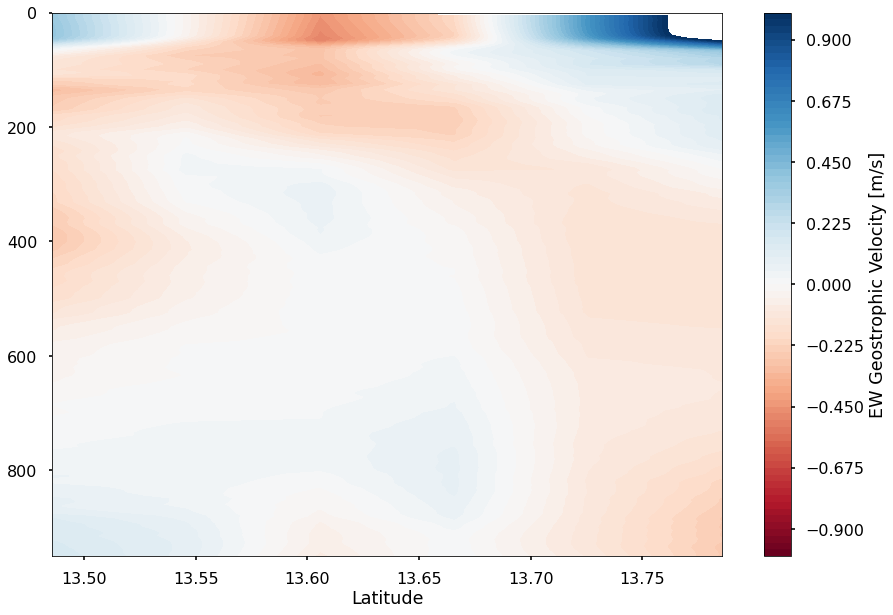

In [48]:
plt.figure(figsize=(15,10))
plt.contourf(stvin_df2.latitude,stvin_df2.depth,stvin_df2.VgeoEW,cmap='RdBu',levels=np.arange(-1,1.01,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

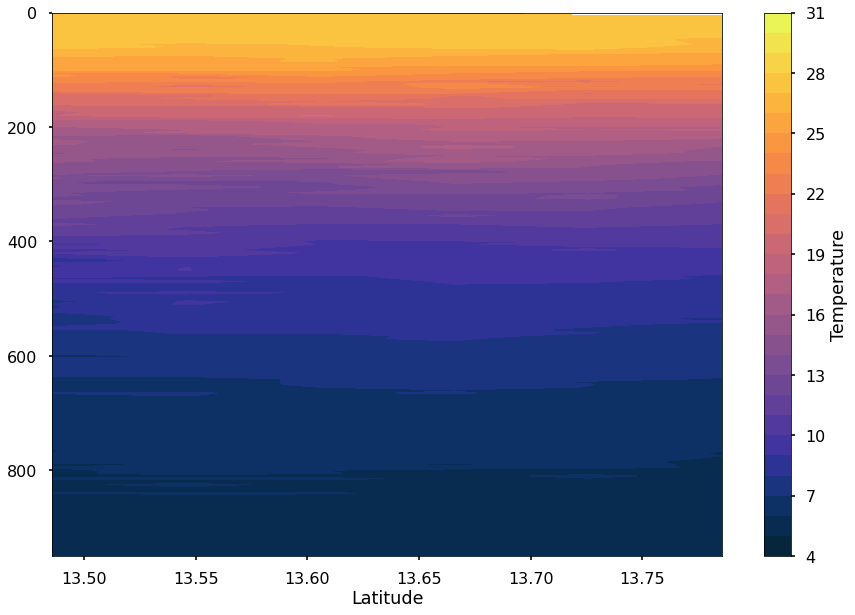

In [49]:
plt.figure(figsize=(15,10))
plt.contourf(stvin_df2.latitude,stvin_df2.depth,stvin_df2.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

## St Lucia #1

In [50]:
stluc_df1 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2022-11-24T05:00:00Z', end_time   = '2022-11-25T15:30:00Z', lat_grid_dy=0.06,geo_dz=5)

save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/St_Lucia_Transect_1_2022.nc'

stluc_df1.to_netcdf(save_name)

stluc_df1

/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


<xarray.Dataset>
Dimensions:      (depth: 191, latitude: 3)
Coordinates:
  * depth        (depth) int64 0 5 10 15 20 25 30 ... 925 930 935 940 945 950
  * latitude     (latitude) float64 14.25 14.31 14.37
    start_time   datetime64[ns] 2022-11-24T05:08:03.480000
    end_time     datetime64[ns] 2022-11-25T15:20:29.430000
    mid_time     datetime64[ns] 2022-11-24T22:14:16.455000
Data variables:
    Vgeo         (depth, latitude) float64 -0.6367 -0.3851 ... -0.1973 -0.395
    VgeoEW       (depth, latitude) float64 -0.6364 -0.3849 ... -0.1972 -0.3949
    density      (depth, latitude) float64 1.023e+03 1.023e+03 ... 1.028e+03
    temperature  (depth, latitude) float64 28.08 28.15 28.12 ... 5.181 4.801
    salinity     (depth, latitude) float64 35.64 35.63 35.68 ... 35.03 35.08
    oxygen       (depth, latitude) float64 nan nan nan nan ... nan nan 177.1
    mean_du      (latitude) float64 -0.1405 -0.1304 0.0
Attributes:
    description:    Processed geostrophic velocity, temperature, salinity, de...
    min_lon:        -60.99301766709525
    max_lon:        -60.96324121171689
    mean_lon:       -60.97953365803938
    geo_dz:         5
    dy:             5725.795536177667
    transect_dist:  22903.182144710667

Text(0.5, 0, 'Latitude')

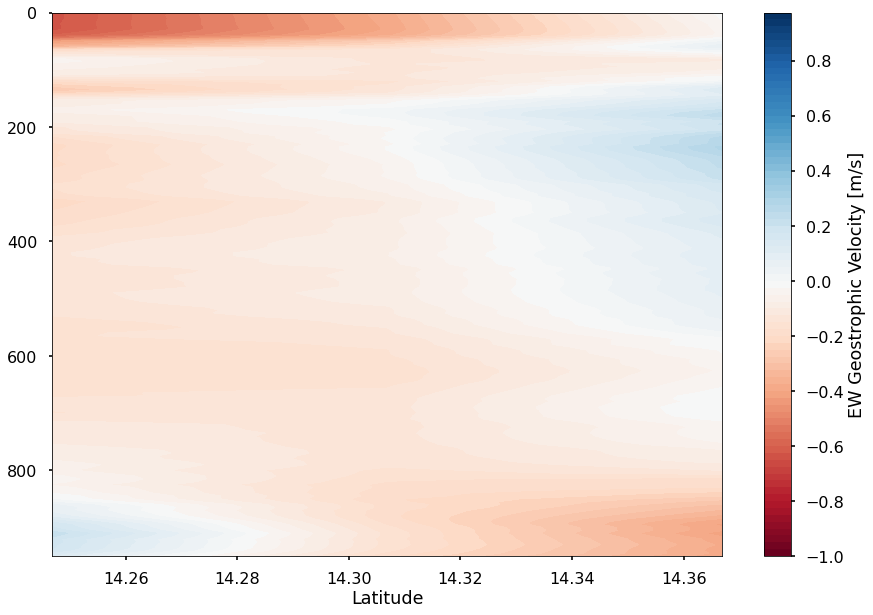

In [51]:
plt.figure(figsize=(15,10))
plt.contourf(stluc_df1.latitude,stluc_df1.depth,stluc_df1.VgeoEW,cmap='RdBu',levels=np.arange(-1,1,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

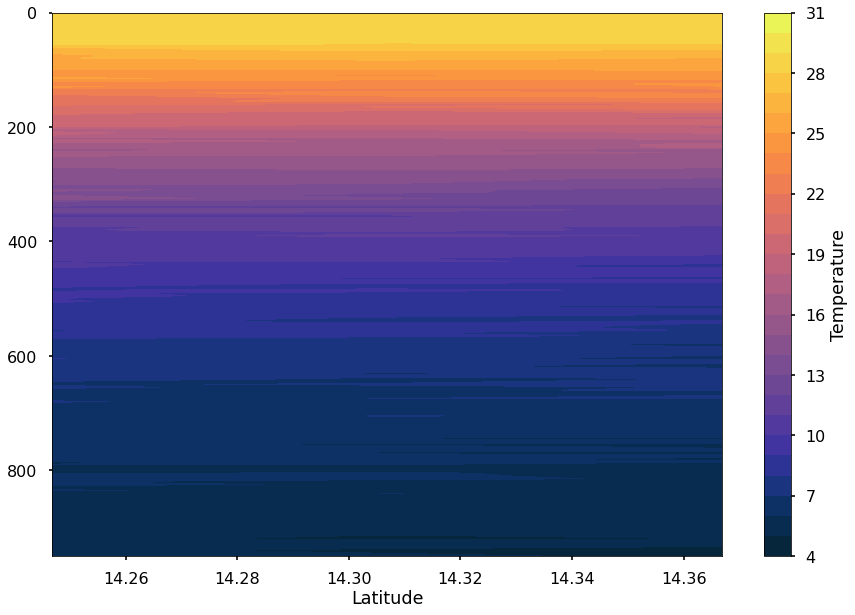

In [52]:
plt.figure(figsize=(15,10))
plt.contourf(stluc_df1.latitude,stluc_df1.depth,stluc_df1.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

## St Lucia #2

In [53]:
stluc_df2 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2022-12-03T09:30:00Z', end_time   = '2022-12-04T07:00:00Z', lat_grid_dy=0.06,geo_dz=5)


save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/St_Lucia_Transect_2_2022.nc'

stluc_df2.to_netcdf(save_name)


stluc_df2


/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


<xarray.Dataset>
Dimensions:      (depth: 191, latitude: 3)
Coordinates:
  * depth        (depth) int64 0 5 10 15 20 25 30 ... 925 930 935 940 945 950
  * latitude     (latitude) float64 14.26 14.32 14.38
    start_time   datetime64[ns] 2022-12-03T09:29:38.340000
    end_time     datetime64[ns] 2022-12-04T07:17:08.390000
    mid_time     datetime64[ns] 2022-12-03T20:23:23.365000
Data variables:
    Vgeo         (depth, latitude) float64 0.02421 nan nan ... -0.06151 0.0
    VgeoEW       (depth, latitude) float64 0.0235 nan nan ... -0.05969 0.0
    density      (depth, latitude) float64 1.023e+03 1.023e+03 ... 1.028e+03 nan
    temperature  (depth, latitude) float64 27.94 27.94 nan ... 4.915 4.775 nan
    salinity     (depth, latitude) float64 35.88 35.88 nan ... 35.07 35.09 nan
    oxygen       (depth, latitude) float64 nan nan nan nan ... nan nan nan nan
    mean_du      (latitude) float64 -0.1405 -0.06151 0.0
Attributes:
    description:    Processed geostrophic velocity, temperature, salinity, de...
    min_lon:        -60.99021139263423
    max_lon:        -60.96029882432147
    mean_lon:       -60.97452289080042
    geo_dz:         5
    dy:             5136.145294970095
    transect_dist:  20544.58117988038

Text(0.5, 0, 'Latitude')

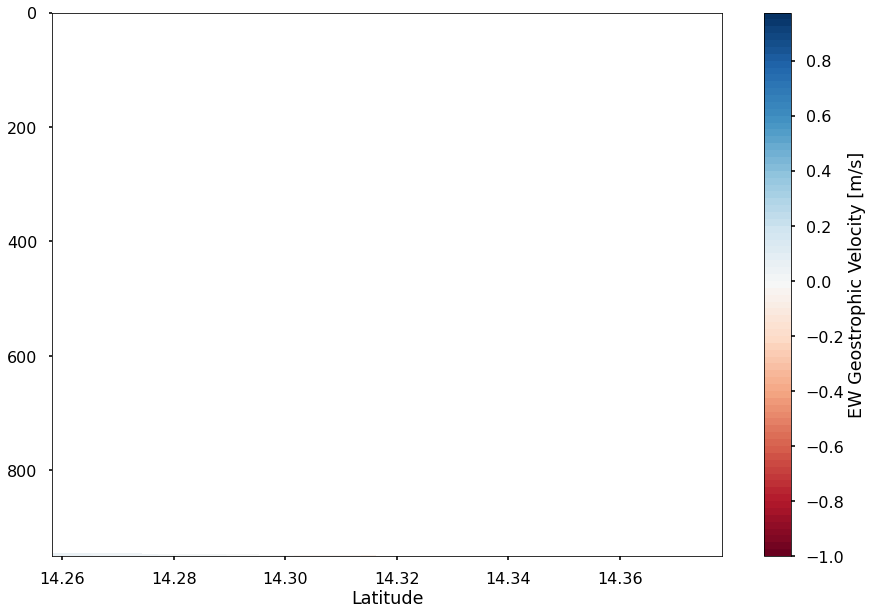

In [54]:
plt.figure(figsize=(15,10))
plt.contourf(stluc_df2.latitude,stluc_df2.depth,stluc_df2.VgeoEW,cmap='RdBu',levels=np.arange(-1,1,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

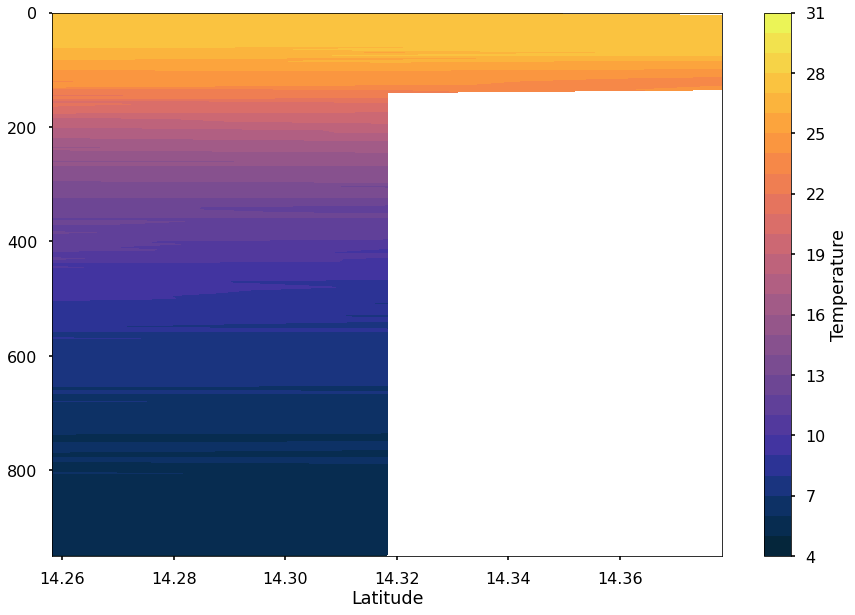

In [55]:
plt.figure(figsize=(15,10))
plt.contourf(stluc_df2.latitude,stluc_df2.depth,stluc_df2.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

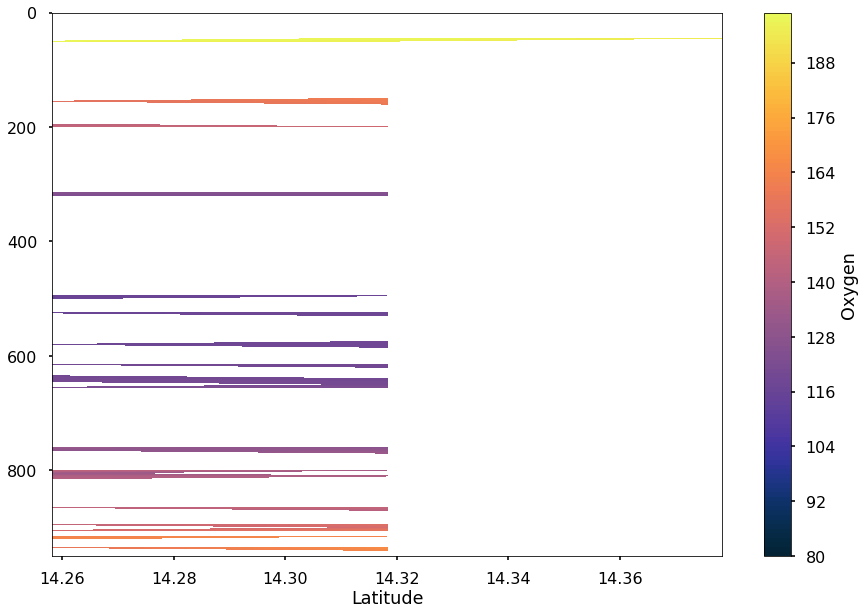

In [56]:
plt.figure(figsize=(15,10))
plt.contourf(stluc_df2.latitude,stluc_df2.depth,stluc_df2.oxygen,cmap=cmo.thermal,levels=np.arange(80,200,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Oxygen')
plt.xlabel('Latitude')

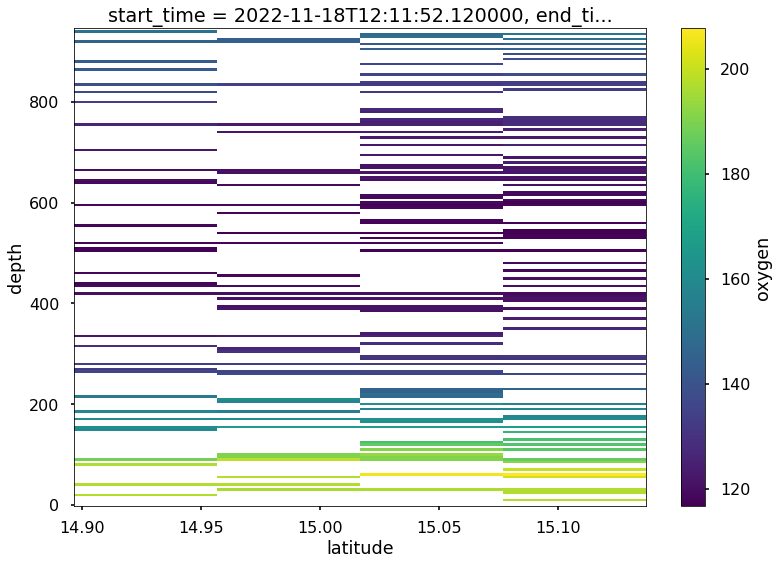

In [57]:
dominica_df1.oxygen.plot()

## Now just look behind islands

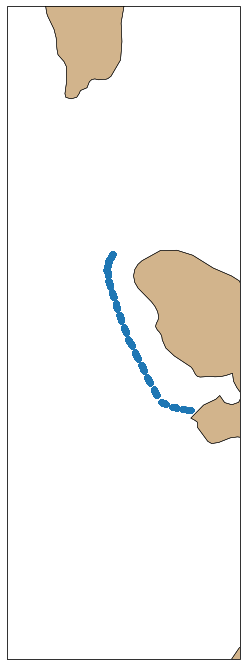

In [58]:
start_time = '2022-11-16T13:29:51Z'
end_time   = '2022-11-18T12:00:00Z'

## First subset by time
testdf = gdf[(gdf.time>= start_time) & (gdf.time<=end_time)]

## Map extent
lon1 = -61.5
lon2 = -61
lat1 = 14
lat2 = 15.4

fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lon1, lon2, lat1, lat2])
LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='tan'
)
ax.add_feature(LAND, zorder=0)

plt.plot(testdf.longitude.values,testdf.latitude.values,'.')


In [59]:
bmartinique_df1 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2022-11-16T13:29:51Z', end_time   = '2022-11-18T12:00:00Z', lat_grid_dy=0.06,geo_dz=5)

save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/Behind_Martinique_Transect_1_2022.nc'

bmartinique_df1.to_netcdf(save_name)



/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Text(0.5, 0, 'Latitude')

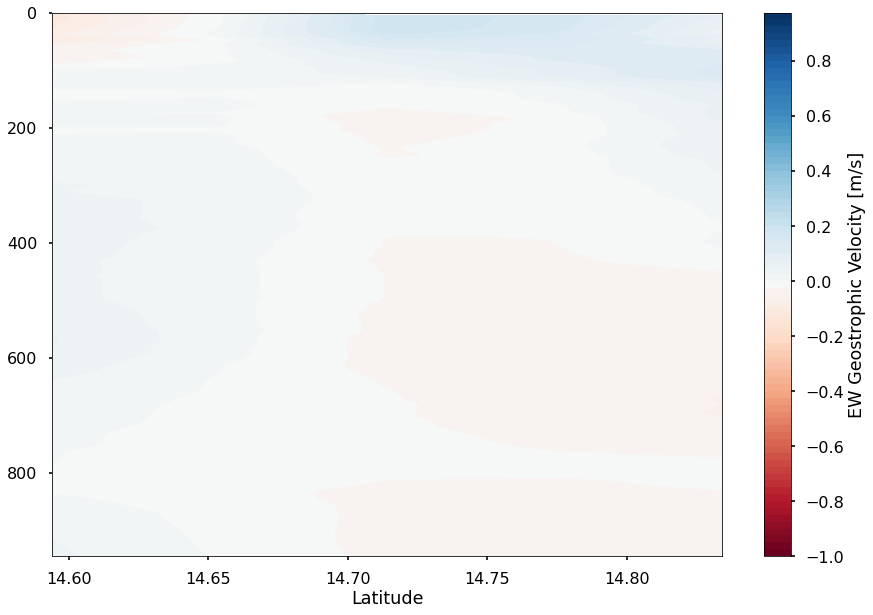

In [60]:
plt.figure(figsize=(15,10))
plt.contourf(bmartinique_df1.latitude,bmartinique_df1.depth,bmartinique_df1.VgeoEW,cmap='RdBu',levels=np.arange(-1,1,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

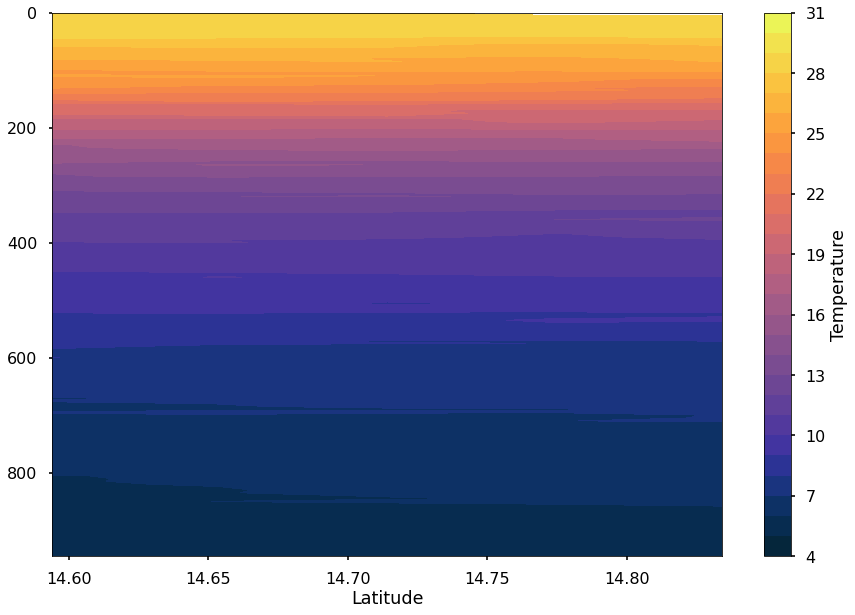

In [61]:
plt.figure(figsize=(15,10))
plt.contourf(bmartinique_df1.latitude,bmartinique_df1.depth,bmartinique_df1.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

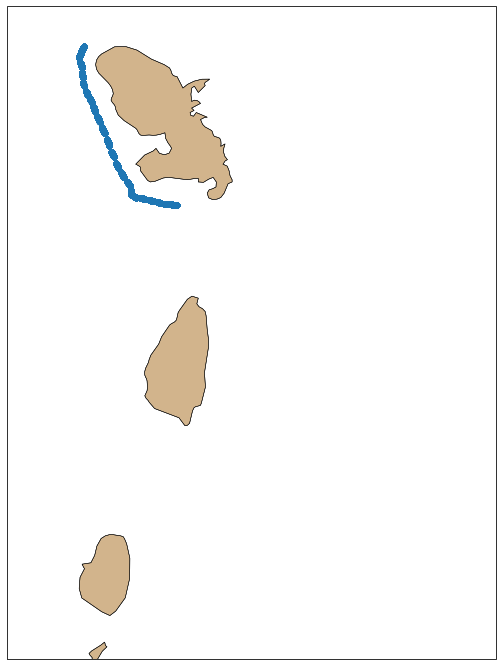

In [62]:
start_time = '2022-11-21T13:00:00Z'
end_time = '2022-11-24T05:00:00Z'



## First subset by time
testdf = gdf[(gdf.time>= start_time) & (gdf.time<=end_time)]

## Map extent
lon1 = -61.5
lon2 = -60
lat1 = 13
lat2 = 15

fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lon1, lon2, lat1, lat2])
LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='tan'
)
ax.add_feature(LAND, zorder=0)

plt.plot(testdf.longitude.values,testdf.latitude.values,'.')


In [63]:
bmartinique_df2 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2022-11-21T13:00:00Z', end_time = '2022-11-24T05:00:00Z', lat_grid_dy=0.06,geo_dz=5)

save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/Behind_Martinique_Transect_2_2022.nc'

bmartinique_df2.to_netcdf(save_name)



/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Text(0.5, 0, 'Latitude')

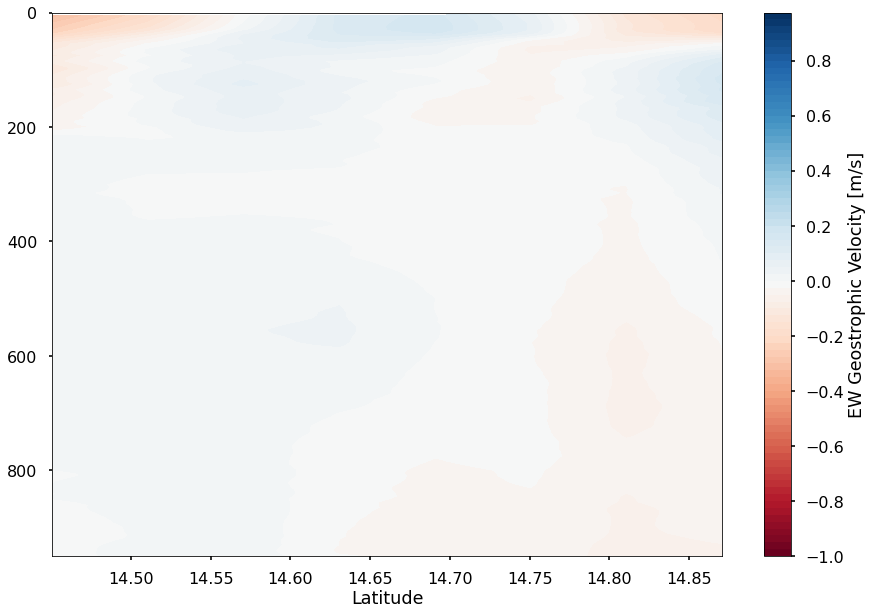

In [64]:
plt.figure(figsize=(15,10))
plt.contourf(bmartinique_df2.latitude,bmartinique_df2.depth,bmartinique_df2.VgeoEW,cmap='RdBu',levels=np.arange(-1,1,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

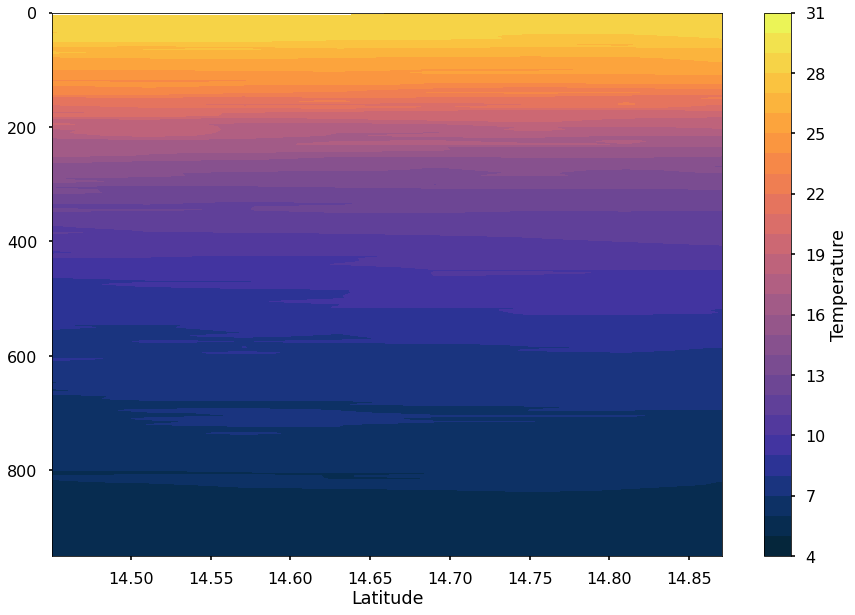

In [65]:
plt.figure(figsize=(15,10))
plt.contourf(bmartinique_df2.latitude,bmartinique_df2.depth,bmartinique_df2.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

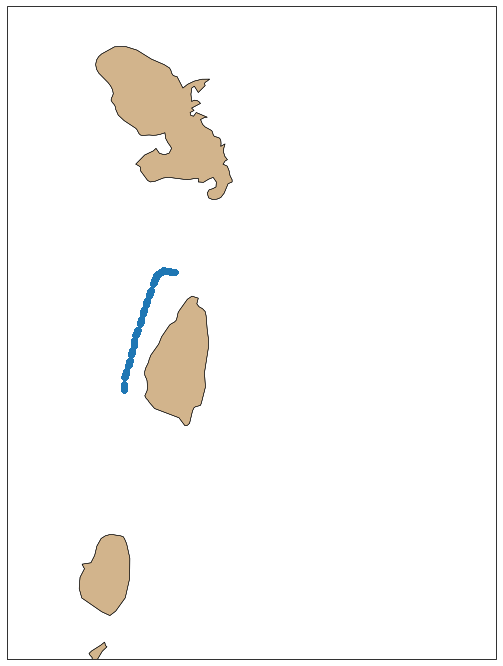

In [66]:
start_time = '2022-11-25T15:30:00Z'
end_time = '2022-11-27T08:00:00Z'

## First subset by time
testdf = gdf[(gdf.time>= start_time) & (gdf.time<=end_time)]

## Map extent
lon1 = -61.5
lon2 = -60
lat1 = 13
lat2 = 15

fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lon1, lon2, lat1, lat2])
LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='tan'
)
ax.add_feature(LAND, zorder=0)

plt.plot(testdf.longitude.values,testdf.latitude.values,'.')


In [67]:
bstvin_df1 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2022-11-25T15:30:00Z', end_time = '2022-11-27T08:00:00Z', lat_grid_dy=0.06,geo_dz=5)

save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/Behind_St_Vincent_Transect_1_2022.nc'

bstvin_df1.to_netcdf(save_name)



/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Text(0.5, 0, 'Latitude')

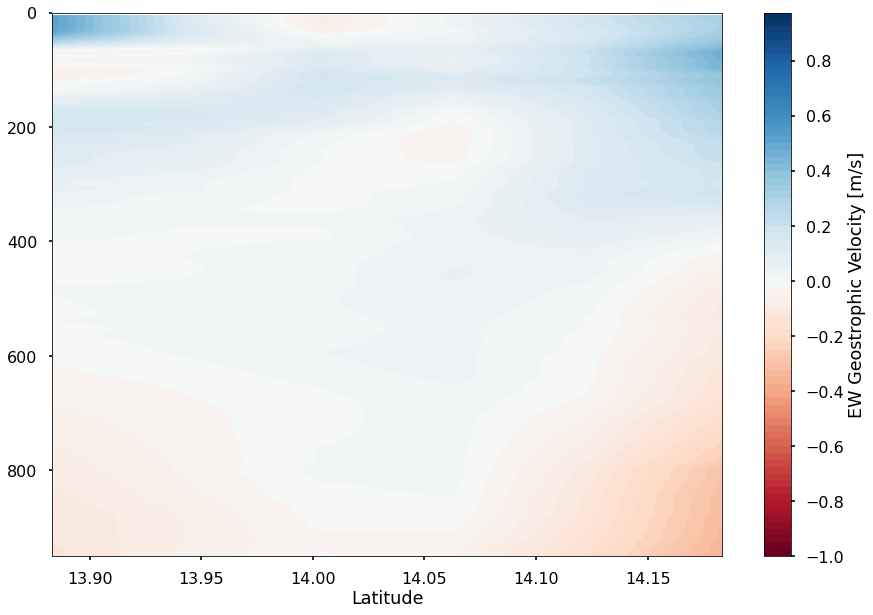

In [68]:
plt.figure(figsize=(15,10))
plt.contourf(bstvin_df1.latitude,bstvin_df1.depth,bstvin_df1.VgeoEW,cmap='RdBu',levels=np.arange(-1,1,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

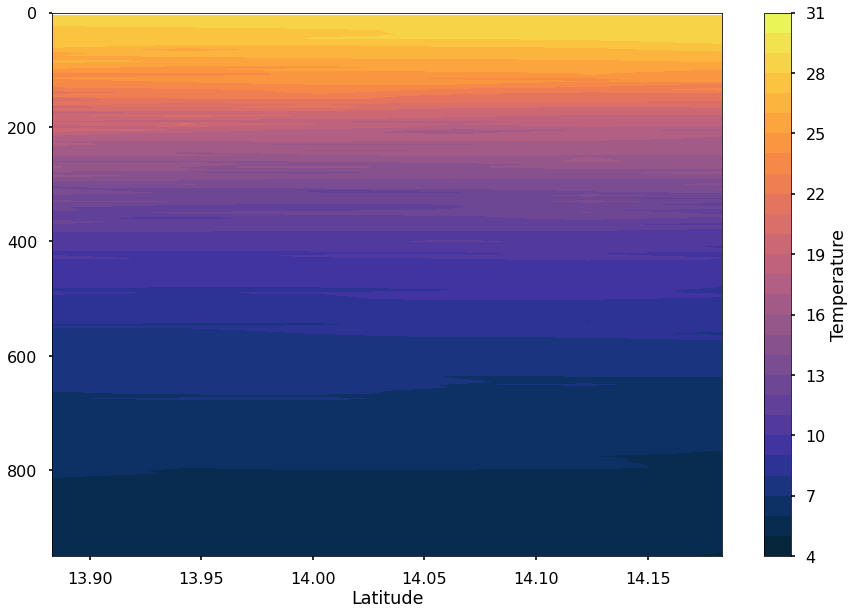

In [69]:
plt.figure(figsize=(15,10))
plt.contourf(bstvin_df1.latitude,bstvin_df1.depth,bstvin_df1.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

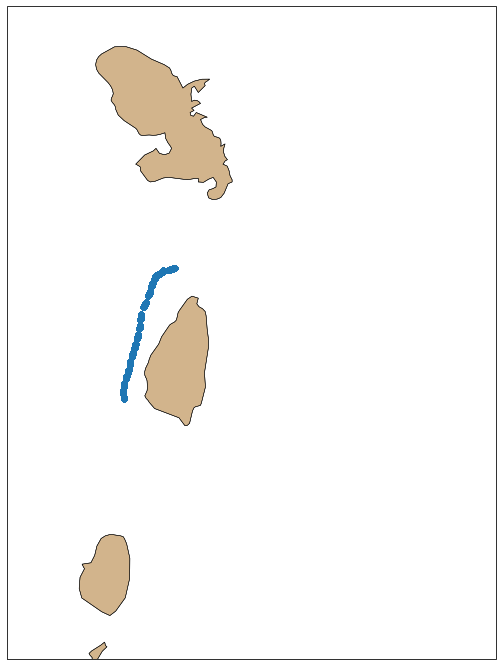

In [70]:
start_time = '2022-12-01T04:00:00Z'
end_time = '2022-12-03T09:30:00Z'

## First subset by time
testdf = gdf[(gdf.time>= start_time) & (gdf.time<=end_time)]

## Map extent
lon1 = -61.5
lon2 = -60
lat1 = 13
lat2 = 15

fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lon1, lon2, lat1, lat2])
LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='tan'
)
ax.add_feature(LAND, zorder=0)

plt.plot(testdf.longitude.values,testdf.latitude.values,'.')


In [71]:
bstvin_df2 = subsect_to_transect_df_to_transport_ds(gdf,start_time = '2022-12-01T04:00:00Z', end_time = '2022-12-03T09:30:00Z', lat_grid_dy=0.06,geo_dz=5)

save_name = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/data/Behind_St_Vincent_Transect_2_2022.nc'

bstvin_df2.to_netcdf(save_name)



/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/joegradone/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Text(0.5, 0, 'Latitude')

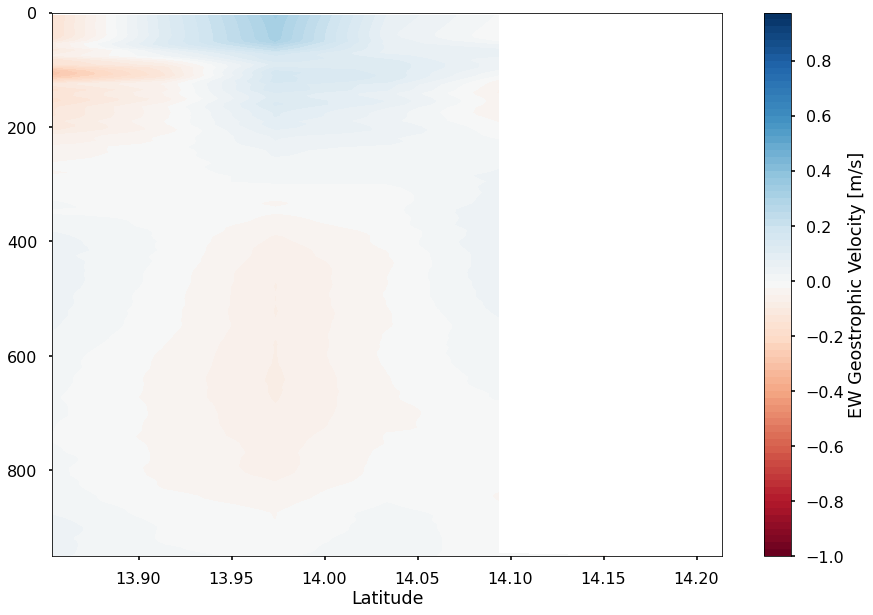

In [72]:
plt.figure(figsize=(15,10))
plt.contourf(bstvin_df2.latitude,bstvin_df2.depth,bstvin_df2.VgeoEW,cmap='RdBu',levels=np.arange(-1,1,0.025))
plt.gca().invert_yaxis()
plt.colorbar(label='EW Geostrophic Velocity [m/s]')
plt.xlabel('Latitude')

Text(0.5, 0, 'Latitude')

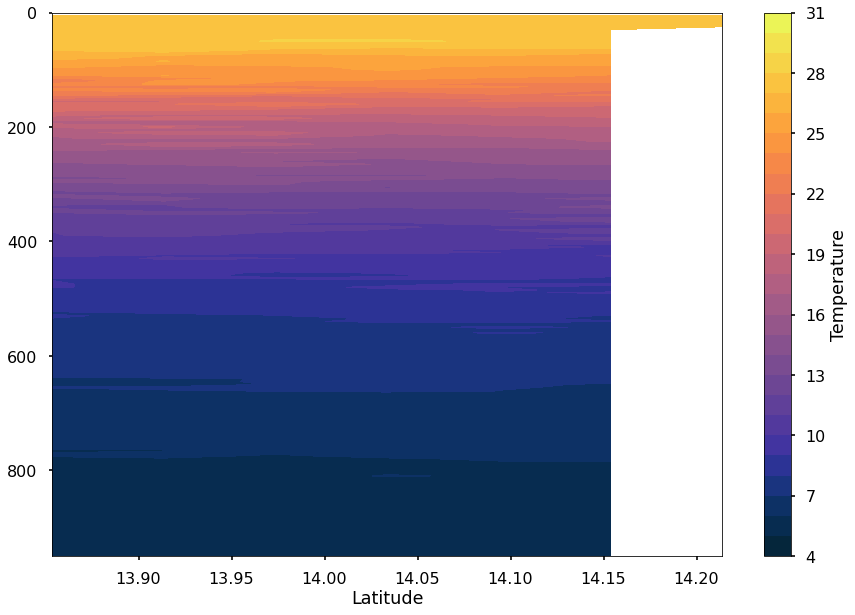

In [73]:
plt.figure(figsize=(15,10))
plt.contourf(bstvin_df2.latitude,bstvin_df2.depth,bstvin_df2.temperature,cmap=cmo.thermal,levels=np.arange(4,32,1))
plt.gca().invert_yaxis()
plt.colorbar(label='Temperature')
plt.xlabel('Latitude')

In [74]:
bstvin_df2.depth[np.nanargmin(np.abs(bstvin_df2.temperature.values-20),axis=0)].values

array([165, 170, 175, 165, 165, 165,  25])

In [75]:
def isotherm(df,val):
    ind = np.nanargmin(np.abs(df.temperature.values-val),axis=0)
    depths = df.depth[ind].values
    return depths
    

In [76]:
np.mean(isotherm(bstvin_df2,20))

147.14285714285714

In [77]:
np.mean(isotherm(bstvin_df1,20))

175.83333333333334

In [78]:
np.mean(isotherm(stvin_df1,20))

171.66666666666666

In [79]:
np.mean(isotherm(stvin_df2,20))

166.66666666666666

In [80]:
np.mean(isotherm(stluc_df1,20))

180.0

In [81]:
np.mean(isotherm(stluc_df2,20))

156.66666666666666

In [82]:
np.mean(isotherm(bmartinique_df1,20))

175.0

In [83]:
np.mean(isotherm(bmartinique_df2,20))

172.5

In [84]:
np.mean(isotherm(dominica_df1,20))

176.25

In [85]:
np.mean(isotherm(dominica_df2,20))

188.75

In [86]:
dom_trans_1 = np.nansum(dominica_df1.VgeoEW.values*dominica_df1.attrs['geo_dz']*dominica_df1.attrs['dy'])/(10**6)
dom_trans_1

-1.6963478083603247

In [87]:
dom_trans_2 = np.nansum(dominica_df2.VgeoEW.values*dominica_df2.attrs['geo_dz']*dominica_df2.attrs['dy'])/(10**6)
dom_trans_2

-1.5337028340572132

In [88]:
stluc_trans_1 = np.nansum(stluc_df1.VgeoEW.values*stluc_df1.attrs['geo_dz']*stluc_df1.attrs['dy'])/(10**6)
stluc_trans_1

-1.4802760626509124

In [89]:
stluc_trans_2 = np.nansum(stluc_df2.VgeoEW.values*stluc_df2.attrs['geo_dz']*stluc_df2.attrs['dy'])/(10**6)
stluc_trans_2

-0.6701110539567885

In [90]:
stvin_trans_1 = np.nansum(stvin_df1.VgeoEW.values*stvin_df1.attrs['geo_dz']*stvin_df1.attrs['dy'])/(10**6)
stvin_trans_1

-1.517985518355002

In [91]:
stvin_trans_2 = np.nansum(stvin_df2.VgeoEW.values*stvin_df2.attrs['geo_dz']*stvin_df2.attrs['dy'])/(10**6)
stvin_trans_2

-1.3248549643878365

In [92]:
np.mean([dom_trans_1,dom_trans_2])

-1.615025321208769

In [93]:
np.std([dom_trans_1,dom_trans_2])

0.08132248715155577

In [94]:
np.mean([stluc_trans_1,stluc_trans_2])

-1.0751935583038503

In [95]:
np.std([stluc_trans_1,stluc_trans_2])

0.40508250434706194

In [96]:
np.mean([stvin_trans_1,stvin_trans_2])

-1.4214202413714192

In [97]:
np.std([stvin_trans_1,stvin_trans_2])

0.09656527698358275

## Summary of Transports

| Passage | Johns et al. (2002) | RU29 |
| --- | --- | --- |
| Dominica | 1.6 ± 1.2 Sv | 1.59 ± 0.1 Sv  |
| St. Lucia | 1.5 ± 2.4 Sv | 1.18 ± 0.3 Sv  |
| St. Vincent | 2.9 ± 2.2 Sv | 1.36 ± 0.1 Sv  |